# Speck Analysis Notebook

The following block initializes the chipwhisperer, as always

In [1]:
import chipwhisperer as cw
import time

In [16]:
# Path to the Speck .hex file for reflashing
PATH="/home/juan/documents/chipwhisperer/hardware/victims/firmware/simplespeck/simple-speck-CWLITEARM.hex"

In [70]:
scope.dis()

In [71]:
def flash(scope, prog):
    cw.program_target(scope, prog, PATH)

def reset_target(scope):
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.05)

try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()

try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer😍")

prog = cw.programmers.STM32FProgrammer
time.sleep(0.05)
scope.default_setup()

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


INFO: Found ChipWhisperer😍


**Reset the target if required:**

In [49]:
reset_target(scope)

**Reflash the target if required:**

In [72]:
flash(scope, prog)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5827 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5827 bytes


**Set an encryption key:**

In [74]:
# 32 bytes of encryption key
encryption_key = b"\x00\x01\x02\x03\x04\x05\x06\x07\x08\x09\x0a\x0b\x0c\x0d\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f"

if len(encryption_key) == 32:
    target.simpleserial_write("s", encryption_key)
    target.simpleserial_read("o", 32)

**Get the encryption key:**

In [75]:
target.simpleserial_write("k", b'\x00'*16)
print(target.simpleserial_read("o", 32))

CWbytearray(b'00 01 02 03 04 05 06 07 08 09 0a 0b 0c 0d 0e 0f 10 11 12 13 14 15 16 17 18 19 1a 1b 1c 1d 1e 1f')


**Encrypt a 16-byte block:**

In [76]:
pt = b"\x70\x6f\x6f\x6e\x65\x72\x2e\x20\x49\x6e\x20\x74\x68\x6f\x73\x65"
target.simpleserial_write("e", pt)
print(target.simpleserial_read("c", 16))

CWbytearray(b'43 8f 18 9c 8d b4 ee 4e 3e f5 c0 05 04 01 09 41')


**Plot the power consumption of the encryption step:**

In [77]:
def trace_encryption():
    global scope, target
    pt = b"\x70\x6f\x6f\x6e\x65\x72\x2e\x20\x49\x6e\x20\x74\x68\x6f\x73\x65"
    return cw.capture_trace(scope, target, pt, b"e")

In [88]:
reset_target(scope)
pt = trace_encryption()

OSError: Scope is not connected. Connect it first...

<IPython.core.display.Javascript object>


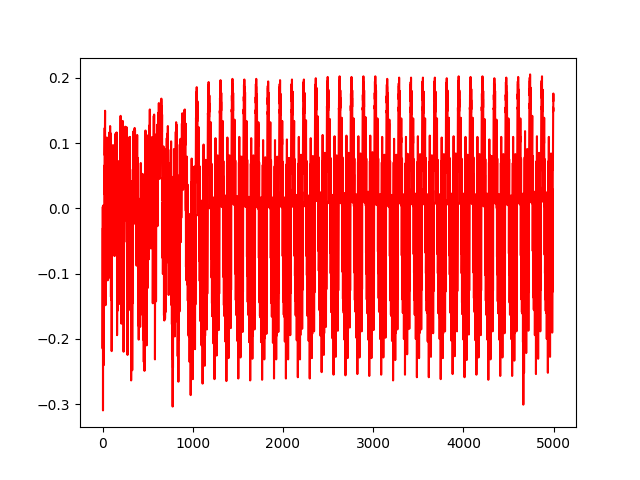

In [86]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.plot(pt.wave, "r")
plt.show()
scope.dis()